# CATRA experiments and analysis

### Common imports

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set(font_scale=1.5)
import experiments

In [2]:
#! cat results/*.log > master-results.log

### Constants

In [3]:
commit = "5810e6d"
logfile = f"master-results.log"
TIMEOUT_S = 30 # FIXME read from log

##  Instances solved
How many instances can we solve, in general?

In [9]:
runtimes = experiments.log2df(logfile)

In [5]:
best_status = runtimes.groupby('instance').status.min()

How many instances for the respective backends?

In [6]:
runtimes.groupby(['backend']).size()

backend
baseline    34297
lazy        34297
nuxmv       34297
dtype: int64

In [7]:
NR_INSTANCES = runtimes.instance.unique().size

In [8]:
timeout_instances = best_status[best_status == Status.TIMEOUT].reset_index().instance
#runtimes = runtimes[~runtimes['instance'].isin(timeout_instances)]

How many instances had all solvers time out?

In [9]:
timeout_instances.size

14569

In [10]:
#results_per_instance = runtimes.groupby('instance').size()
#tried_on_all = results_per_instance[results_per_instance == runtimes.backend.cat.categories.size ].reset_index().instance
# runtimes = runtimes[runtimes['instance'].isin(tried_on_all)]

## Correctness check

In [49]:
success_runs = runtimes[runtimes['status'] < Status.TIMEOUT]
success_runs_by_instance = success_runs.groupby(['instance'])

nr_statuses = success_runs_by_instance.status.nunique().reset_index()
nr_statuses[nr_statuses['status'] != 1]

,instance,status


It's empty so they all concur!

In [68]:
success_runs.groupby(['instance', 'status']).size()

instance                                     status           
../../../amanda/deduped-benchmarks/100.par   Status.SAT           1
                                             Status.UNSAT         0
                                             Status.TIMEOUT       0
                                             Status.MEMORY_OUT    0
                                             Status.ERROR         0
                                                                 ..
../../../amanda/deduped-benchmarks/9997.par  Status.SAT           2
                                             Status.UNSAT         0
                                             Status.TIMEOUT       0
                                             Status.MEMORY_OUT    0
                                             Status.ERROR         0
Length: 98640, dtype: int64

### Errors

In [50]:
runtimes[runtimes['status'] > Status.TIMEOUT]

,backend,instance,status,runtime
61343,nuxmv,../../../amanda/deduped-benchmarks/36399.par,Status.ERROR,inf
61439,nuxmv,../../../amanda/deduped-benchmarks/36423.par,Status.ERROR,inf
61445,nuxmv,../../../amanda/deduped-benchmarks/36379.par,Status.ERROR,inf
61502,nuxmv,../../../amanda/deduped-benchmarks/37210.par,Status.ERROR,inf
61637,nuxmv,../../../amanda/deduped-benchmarks/36363.par,Status.ERROR,inf
73697,nuxmv,../../../amanda/deduped-benchmarks/36417.par,Status.ERROR,inf
73817,nuxmv,../../../amanda/deduped-benchmarks/36411.par,Status.ERROR,inf
74123,nuxmv,../../../amanda/deduped-benchmarks/36412.par,Status.ERROR,inf
74174,nuxmv,../../../amanda/deduped-benchmarks/36422.par,Status.ERROR,inf
101323,lazy,../../../amanda/deduped-benchmarks/5922.par,Status.ERROR,inf


## Outcomes

How many instances are in each category, per backend?

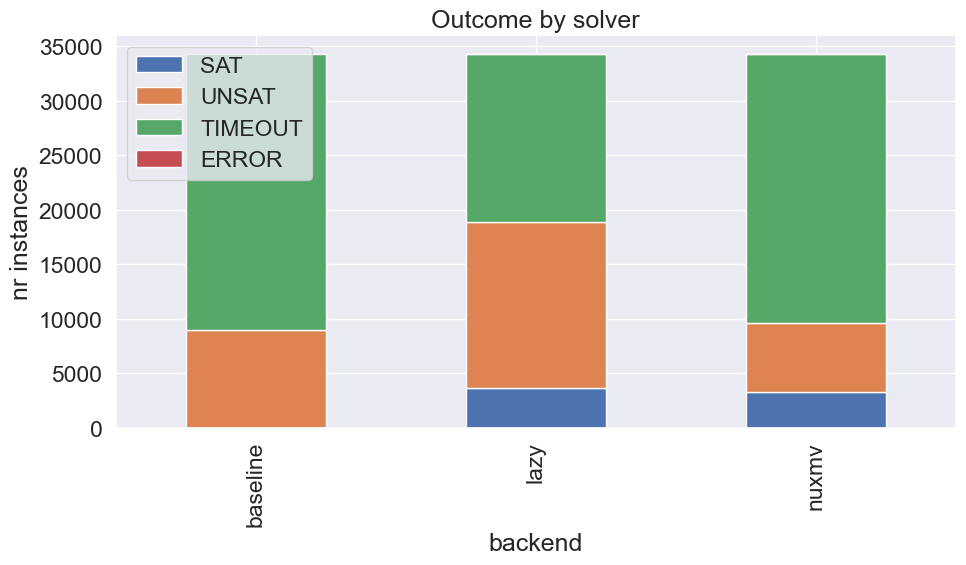

In [26]:
fig, ax = plt.subplots()
runtime_by_status = runtimes.groupby(['backend', 'status']).size().reset_index()
runtime_by_status = runtime_by_status[runtime_by_status[0] > 0]
runtime_by_status.rename(columns = {0: 'count'}, inplace = True)
runtime_by_status = runtime_by_status.set_index(['backend', 'status'])
runtime_by_status.unstack().plot.bar(figsize=(10,6), 
                                     stacked=True, 
                                     ylabel="nr instances",
                                     title="Outcome by solver", ax=ax)
ax.legend([str(heading).replace("Status.", "") for _, heading in runtime_by_status.unstack().columns])
plt.tight_layout()
plt.savefig(f'{commit}-by-solver.pdf', dpi=300)

/var/folders/tw/dzvqtdd943z519845l595qbh0000gq/T/ipykernel_51833/3013270416.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  nr_solved.groupby('backend').sum().plot.bar(legend=False,


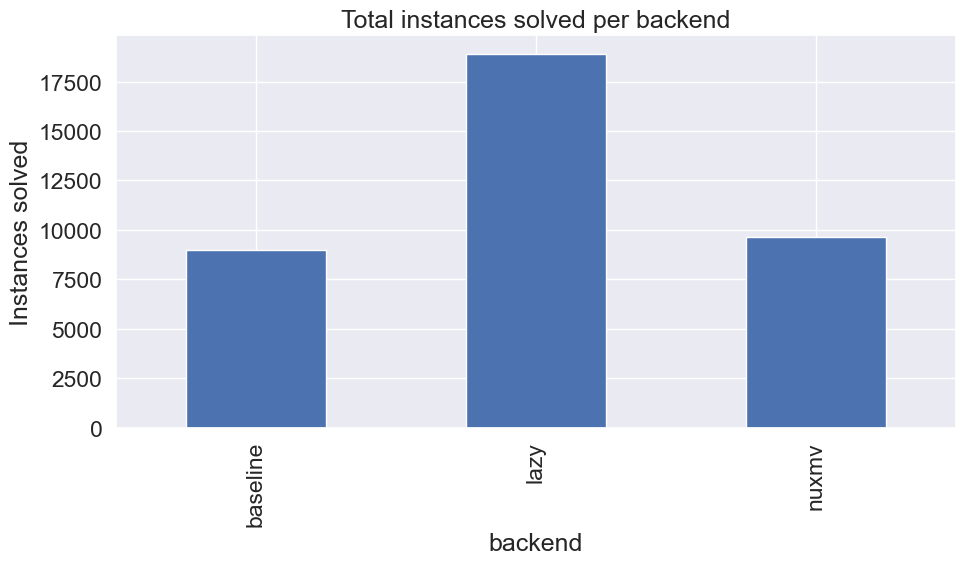

In [27]:
nr_solved = runtimes.groupby(['backend', 'status']).size().reset_index()
nr_solved = nr_solved.loc[nr_solved.status.apply(lambda s: s in [Status.SAT, Status.UNSAT])]
nr_solved.groupby('backend').sum().plot.bar(legend=False,
                                            figsize=(10,6),
                                            ylabel="Instances solved", 
                                            title="Total instances solved per backend")
plt.tight_layout()

How do the respective solvers do on each type of instance?

In [28]:
by_sat_status = pd.DataFrame(runtimes.groupby('instance').status.min())
by_sat_status['kind'] = by_sat_status['status'].astype("category")
by_sat_status['kind'] = by_sat_status.kind.cat.set_categories([Status.SAT, Status.UNSAT])
del(by_sat_status['status'])

known_solved_with_kind = runtimes[runtimes['status'] < Status.TIMEOUT]\
    .join(by_sat_status, on='instance')

In [60]:
tbl = pd.pivot_table(known_solved_with_kind, values=['runtime'], 
               index=['kind'], columns=['backend'],
               aggfunc='count')['runtime']
tbl.style.to_latex("solved_pivot_table.tex", hrules=True)
tbl

backend,baseline,lazy,nuxmv
instance_kind,,,
Status.SAT,6,3692,3288
Status.UNSAT,8958,15197,6356


## Execution time
For solved instances, for each backend plot the distribution of runtimes

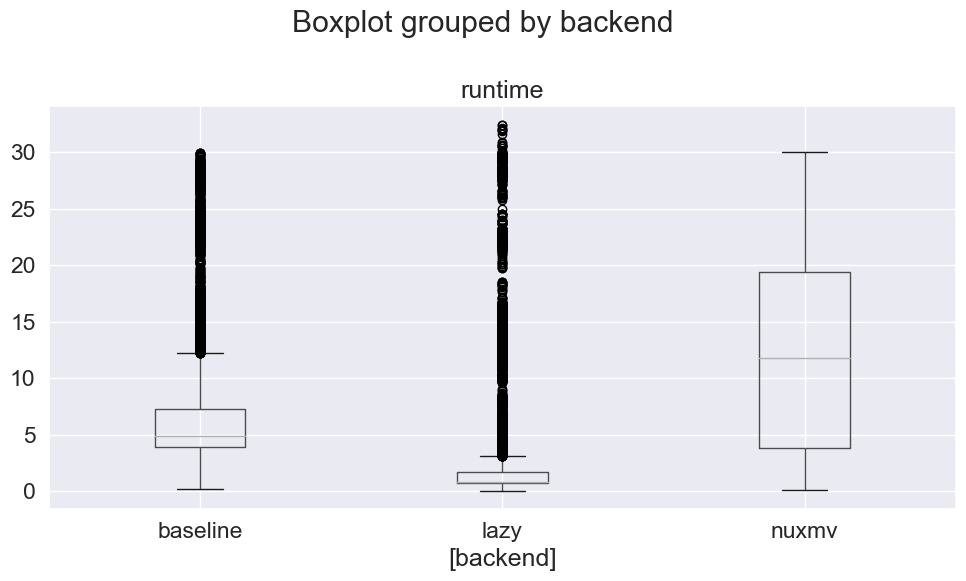

In [30]:
runtimes[runtimes['status'] < Status.TIMEOUT].boxplot(by='backend', figsize=(10,6))
plt.tight_layout()
plt.savefig(f'{commit}-time-boxplot.pdf', dpi=300)

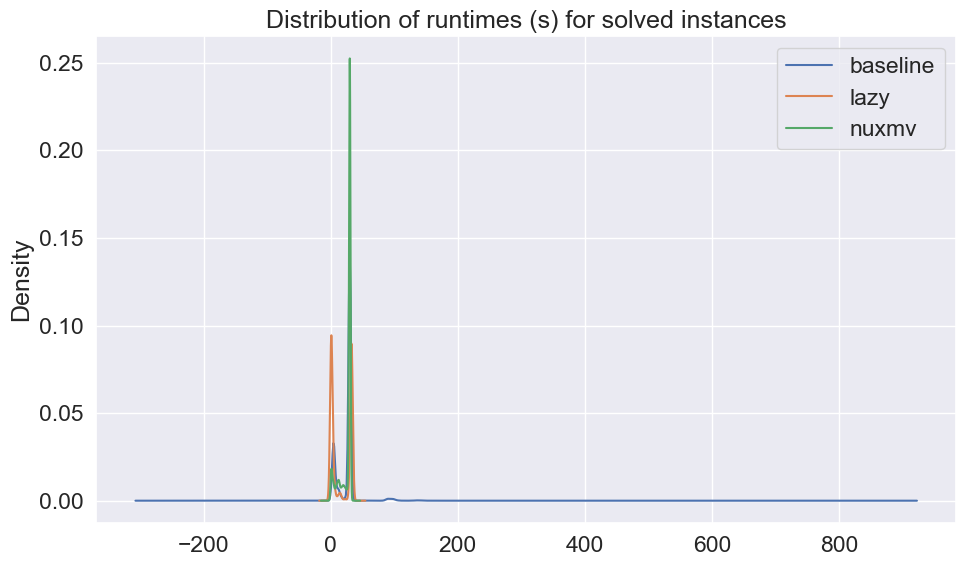

In [31]:
runtimes[runtimes['runtime'] < float('inf')]\
    .set_index('instance')\
    .groupby('backend')\
    .runtime\
    .plot.kde(xlabel='Runtime (s)',
              legend=True,
              figsize=(10, 6),
              title='Distribution of runtimes (s) for solved instances')
plt.tight_layout()

## Scalability (this is the cactus plot section)
If we add more time, how many more instances can we solve?

In [2]:
nr_total, cactus_data = experiments.prepare_cactus_plot("results/catra-0.1.4-5.experiments.batch_0.log", 
                                  timeout_s=120, step_size=1)

AttributeError: 'DataFrame' object has no attribute 'nr_solved'

AttributeError: 'DataFrame' object has no attribute 'instance'

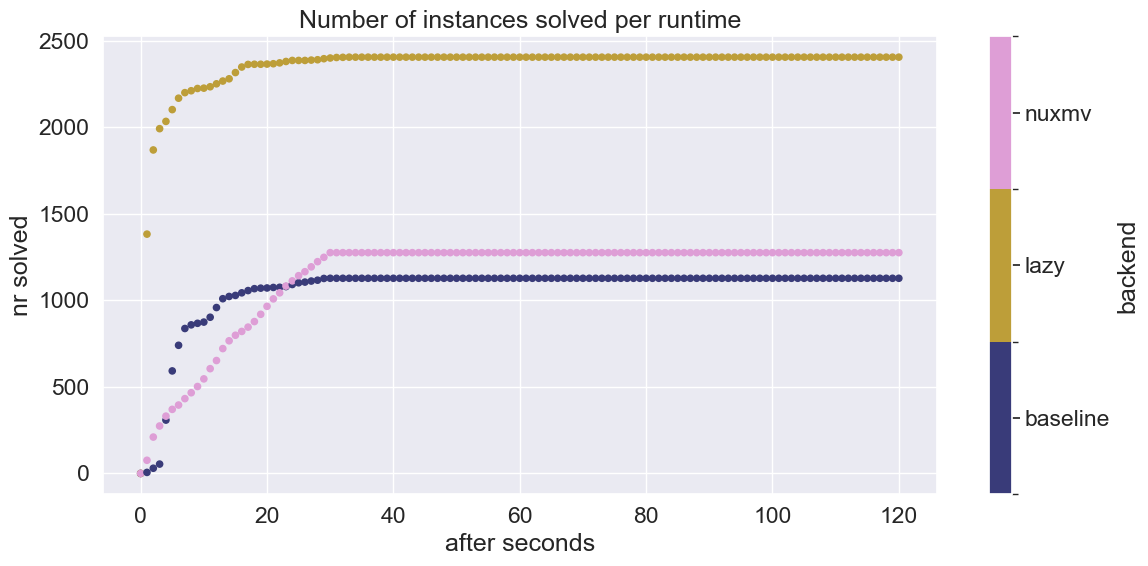

In [4]:
# If we don't use a subplot here, the x ticks and labels all disappear, for no good reason.
fig, ax = plt.subplots()

cactus_data.plot.scatter(x='after', 
                         y='nr solved', 
                         c='backend',
                         xlabel='after seconds',
                         ax=ax,
                         s=20,
                         figsize=(12,6),
                         title="Number of instances solved per runtime",
                         cmap=plt.cm.get_cmap('tab20b'))
fig.tight_layout()
ax.set_ylim(0, nr_total)
plt.savefig(f'{commit}-cactus.pdf', dpi=300)

## Duels

This is where we compare pairs of backends. In order to make timeouts plottable we set the runtime of an instance that timed out to the timeout value.

KeyError: 'lazy'

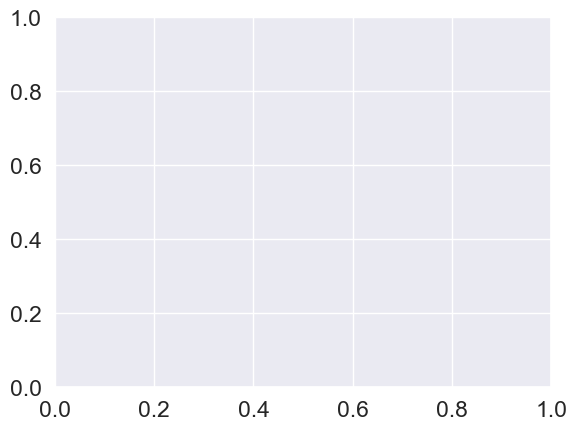

In [22]:
runtimes_by_backend = known_solved.set_index(['instance', 'backend']).runtime\
    .unstack()\
    .replace(to_replace=float('inf'), value=TIMEOUT_S)
runtimes_by_backend.plot.scatter(x='nuxmv', y='lazy', 
                                 title=f"Lazy vs nuXmv runtime, where timeout = {TIMEOUT_S}s", 
                                 s=1, 
                                 xlabel="nuXmv, runtime (s)")
plt.tight_layout()
plt.savefig(f'{commit}-duels-lazy-nuxmv-scatter.pdf', dpi=300)


runtimes_by_backend.plot.scatter(x='baseline', y='lazy', 
                                 title=f"Lazy vs baseline runtime, where timeout = {TIMEOUT_S}s", 
                                 s=1)

plt.tight_layout()
plt.savefig(f'{commit}-duels-lazy-baseline-scatter.pdf', dpi=300)

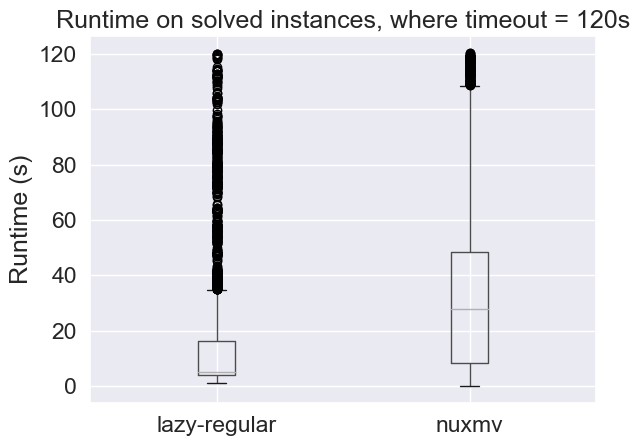

In [23]:
fig = runtimes_by_backend.boxplot()
fig.set_ylabel("Runtime (s)")
fig.set_title(f"Runtime on solved instances, where timeout = {TIMEOUT_S}s")
plt.tight_layout()